# Standard Hartigan's algorithm

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

In [ ]:
## TODO: Complete implementation in fit and _move_centroids methods
## TODO: Update documentation for second return of fit (also TBD in Lloyds)
## TODO: Implement safe and unsafe mode
## TODO: Redefine _delta_cost arguments to be consistent with the operation done
class Hartigan:
    """
    Perform k-means clustering using standard Hartigan's algorithm.
    """
    
    def __init__(self):
        self.data = None
        self.centroids = None
        self.y_pred = None
    
    
    def fit(self, data : pd.DataFrame, k : int, seed : int = None):
        """
        Fit the model to the data.

        Parameters
        ----------
        data : pd.DataFrame
            nxd DataFrame of n samples with d features
        k : int
            Number of clusters
        seed : int
            Seed for random generator

        Returns
        -------
        np.ndarray
            Array of length n with cluster assignments for each sample
        np.ndarray
            Array of shape (k, d) with cluster centroids
        """

        assert isinstance(data, pd.DataFrame), "data must be a pandas DataFrame"
        assert isinstance(k, int), "k must be an int"
        assert k <= len(data), "k must be at most the number of samples"

        self.data = data

        np.random.seed(seed)

        # sample k row indexes and make them centroids
        centroid_ids = np.random.choice(len(data), k, replace=False)
        centroids = data.loc[centroid_ids, :]
        print('init centroids ids:', centroid_ids)
        print('init centroids:\n', centroids)
        
        new_centroids, closest_points_ids = self._move_centroids(data, centroids)

        # create an empty dictionary of new candidates
        candidates = {}

        while True:

            # break at convergence
            if not candidates:      ## {} -> False
                break

            ## TODO: Implement
            for datapoint in data.index:
                
                # calculate cost of current assignment which remains invariant
                cost = self._distance(datapoint, centroids.loc[closest_points_ids[datapoint], :])

                # TODO: define old_centroid and iterate only on other centroids
                for centroid_id in new_centroids.index:
                    ## TODO: CHECK!
                    delta_cost = self._delta_cost(datapoint, cost, centroid_id, new_centroids)
                    if delta_cost < 0 and (candidates.get(datapoint) is None or delta_cost < candidates[datapoint]['delta_cost']):
                        candidates[datapoint] = {'delta_cost': delta_cost, 'old_centroid_id': old_centroid_id, 'new_centroid': centroid_id}
        
        self.centroids = centroids
        self.y_pred = closest_points_ids

        return centroids, closest_points_ids

    def _move_centroids(self, data, centroids):
        # new_centroids is analogous to centroids
        new_centroids = pd.DataFrame(pd.NA, index=centroids.index, columns=centroids.columns)

        # distances is a (n x k) DataFrame
        distances = pd.DataFrame(index=data.index, columns=centroids.index, dtype=float)

        # iterate on all datapoints
        for point_id in distances.index:
            point = data.loc[point_id, :]

            # calculate distance of point from centroids
            for centroid_id in centroids.index:
                centroid = centroids.loc[centroid_id, :]
                distances.loc[point_id, centroid_id] = self._distance(point, centroid )

        # assign points to closest centroid
        min_centroids = distances.idxmin(axis='columns')
        closest_points_ids = np.zeros(self.data.shape[0], dtype=int)

        for centroid_id in distances.columns:
            ids = min_centroids[min_centroids == centroid_id].index

            closest_points_ids[ids] = centroid_id

            closest_points = data.loc[ids.array, :]
            new_centroids.loc[centroid_id, :] = closest_points.mean()

        return new_centroids, closest_points_ids

    def _distance(self, x1, x2):
        """
        Compute the squared Euclidean distance between two points
        """
        return np.square(np.linalg.norm(x1-x2))

    def _delta_cost(self, datapoint, cost, centroid_id, centroids):
        """
        Compute the change in cost if datapoint is reassigned to centroid_id
        """

        # cost of new assignment
        new_cost = self._distance(datapoint, centroids.loc[centroid_id, :])
        
        return new_cost - cost


In [4]:
def accuracy(y_true : np.ndarray, y_pred : np.ndarray):
    """
    Compute the accuracy of the clustering.
    
    Parameters
    ----------
    y_true : np.ndarray
        True labels of the samples
    y_pred : np.ndarray
        Predicted labels of the samples
    
    Returns
    -------
    float
        Accuracy of the clustering through Hungarian algorithm
    """
    
    assert isinstance(y_true, np.ndarray), "y_true must be a numpy array"
    assert isinstance(y_pred, np.ndarray), "y_pred must be a numpy array"

    # create C matrix
    n_classes = max(max(y_true), max(y_pred)) + 1
    C = np.zeros((n_classes, n_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        C[true_label, pred_label] += 1
    
    # Solve assignment problem
    row_ind, col_ind = linear_sum_assignment(-C)
    
    # Calculate accuracy
    matched = C[row_ind, col_ind].sum()
    accuracy = matched / len(y_true)
    return accuracy


#### some tests

In [ ]:
data = pd.DataFrame([[0,0],[1,1],[20,20],[21,21]])

k_means = Hartigan()
centroids, y_pred = k_means.fit(data, 2)

init centroids ids: [3 1]
init centroids:
     0   1
3  21  21
1   1   1


In [6]:
accuracy(y_pred, np.array([0,0,1,1]))

np.float64(1.0)

In [ ]:
def generate_test_dataframe(n_clusters=3, n_samples=150, n_features=2, seed=None):
    if seed:
        np.random.seed(seed)
    
    # Calculate points per cluster
    points_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters  # To handle uneven division
    
    data = []
    labels = []
    
    for cluster_id in range(n_clusters):
        # Generate random cluster center
        center = np.random.uniform(-10, 10, size=n_features)
        
        # Generate points for this cluster
        n_points = points_per_cluster + (1 if cluster_id < remainder else 0)
        points = np.random.normal(loc=center, scale=1.0, size=(n_points, n_features))
        
        data.append(points)
        labels.extend([cluster_id] * n_points)
    
    # Combine all clusters into one dataset
    data = np.vstack(data)
    labels = np.array(labels)
    
    # Shuffle the dataset
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # Create a DataFrame
    column_names = [f"Feature{i+1}" for i in range(n_features)]
    df = pd.DataFrame(data, columns=column_names)
    df["Label"] = labels
    
    return df

test_df = generate_test_dataframe(10, 1000, 10, seed=42)

k_means = Hartigan()
k_means.fit(test_df.iloc[:, :-1], 10, seed=42)

print('Accuracy:', accuracy(np.array(test_df["Label"]), k_means.y_pred))

init centroids ids: [521 737 740 660 411 678 626 513 859 136]
init centroids:
      Feature1  Feature2  Feature3  Feature4   Feature5  Feature6  Feature7  \
521 -9.558033 -0.955288  5.004327  2.323583  10.305739 -3.608574 -0.637341   
737 -8.557540 -3.506088  4.063249  4.344668  11.528762 -4.539703  0.291597   
740 -2.028188  9.238170  3.849404  2.444638  -4.997603 -5.534690 -7.245141   
660  2.808011  5.519617 -4.609808 -3.618455  -0.860509 -4.555741  8.484914   
411 -1.945288  5.430327 -7.428246  8.323527   0.305620  8.121266 -2.147271   
678  3.896995  2.590766  7.899939 -4.026307   5.188462  0.196091  8.479080   
626 -3.695540 -0.143381 -5.393527  0.590220   9.349823  1.218455 -2.668507   
513  1.775394  4.277720  2.084934 -9.060278  -6.078125  3.394702 -5.391960   
859  6.031470  0.883097  7.280661 -4.723444  -0.865785  5.271398  0.122286   
136  0.435323 -4.382507  7.958847 -9.596048   8.778427  5.719405  0.908802   

     Feature8   Feature9  Feature10  
521 -2.243475  -2.854701

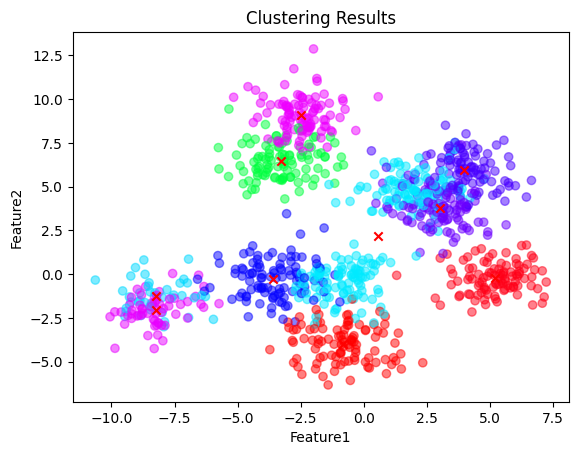

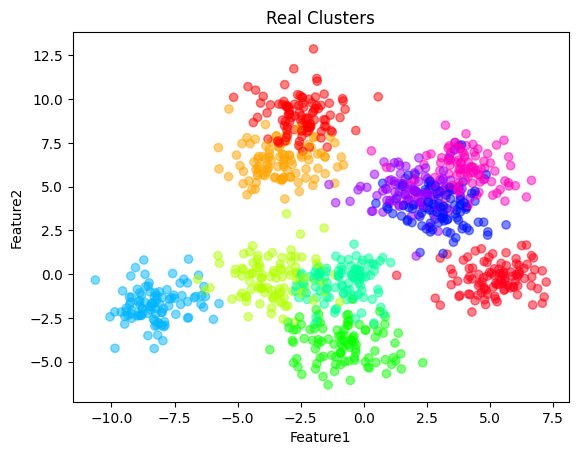

In [41]:
# Plot the data points for two features
plt.scatter(test_df.iloc[:, 0], test_df.iloc[:, 1], cmap='hsv', c=k_means.y_pred, marker='o', alpha=0.5)

# Plot the centroids
plt.scatter(k_means.centroids.iloc[:, 0], k_means.centroids.iloc[:, 1], c='red', marker='x')

plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Clustering Results')
plt.show()

# Plot the real clusters
plt.scatter(test_df.iloc[:, 0], test_df.iloc[:, 1], cmap='hsv', c=np.array(test_df["Label"]), marker='o', alpha=0.5)

plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Real Clusters')
plt.show()
